In [63]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from torchvision import  transforms
import torchvision
import torch
from PIL import Image
from torch_snippets import read
from skimage.segmentation import felzenszwalb
import selectivesearch

In [64]:
# Creating subplots using matplotlib | it will also save the plot to a file
def visualization(image, segments_fz):
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))  # 1 row, 2 columns
    axes[0].imshow(image)  # Displaying the original image
    axes[0].set_title('Original Image')
    axes[0].axis('off')  # Hides the axis

    axes[1].imshow(segments_fz)  # Displaying the segmented image
    axes[1].set_title('Image Segmentation')
    axes[1].axis('off')
    # Save the figure to a file
    # plt.savefig('/kaggle/working/Felzenszwalb_Generated_Image_1.jpg')
    plt.show()
    plt.close(fig)  # Close the plot to free up memory



def saving_bounding_boxes(image, candidates):
    # Create a copy of the image to draw bounding boxes on
    image_with_bbs = image.copy()

    # Draw each bounding box on the image
    for x, y, w, h in candidates:
        cv2.rectangle(image_with_bbs, (x, y), (x + w, y + h), (0, 255, 0), 2)

    # Save the image with bounding boxes drawn on it using imwrite() from OpenCV
    # cv2.imwrite('/kaggle/working/Bounding_Box_Selective_Search_1.jpg', image_with_bbs)

    # Display the image with bounding boxes drawn on it using Matplotlib
    plt.imshow(cv2.cvtColor(image_with_bbs, cv2.COLOR_BGR2RGB))  # Convert BGR to RGB for displaying correctly with Matplotlib
    plt.title('Image with Bounding Boxes')
    plt.axis('off')  # Hide the axis
    plt.show()

def get_predictions(pred, threshold=0.8, objects=None):
    """
    This function will assign a string name to a predicted class and eliminate predictions whose likelihood  is under a threshold 
    
    pred: a list where each element contains a tuple that corresponds to information about  the different objects; Each element includes a tuple with the class yhat, probability of belonging to that class and the coordinates of the bounding box corresponding to the object 
    image : frozen surface
    predicted_classes: a list where each element contains a tuple that corresponds to information about  the different objects; Each element includes a tuple with the class name, probability of belonging to that class and the coordinates of the bounding box corresponding to the object 
    thre
    """

    predicted_classes= [(COCO_INSTANCE_CATEGORY_NAMES[i],p,[(box[0], box[1]), (box[2], box[3])]) for i,p,box in zip(list(pred[0]['labels'].numpy()),pred[0]['scores'].detach().numpy(),list(pred[0]['boxes'].detach().numpy()))]
    predicted_classes=[  stuff  for stuff in predicted_classes  if stuff[1]>threshold ]

    if objects  and predicted_classes :
        predicted_classes=[ (name, p, box) for name, p, box in predicted_classes if name in  objects ]
    return predicted_classes

def draw_box(pred_class, img, rect_th=2, text_size=0.5, text_th=2, download_image=False, img_name="img"):
    """
    draws box around each object 
    
    predicted_classes: a list where each element contains a tuple that corresponds to information about the different objects; Each element includes a tuple with the class name, probability of belonging to that class and the coordinates of the bounding box corresponding to the object 
    image : frozen surface 
   
    """
    image = (np.clip(cv2.cvtColor(np.clip(img.numpy().transpose((1, 2, 0)), 0, 1), cv2.COLOR_RGB2BGR), 0, 1) * 255).astype(np.uint8).copy()

    for predicted_class in pred_class:

        label=predicted_class[0]
        probability=predicted_class[1]
        box=predicted_class[2]
        t = round(box[0][0].tolist())
        l = round(box[0][1].tolist())
        r = round(box[1][0].tolist())
        b = round(box[1][1].tolist())

        # Giving brief information about rectange, class and probability.
        from colorama import Fore
        from colorama import Style
        print(f"\nLabel: {Fore.GREEN}{label}{Style.RESET_ALL}")
        print(f"Box coordinates: {t}, {l}, {r}, {b}")
        print(f"Probability: {probability}")

        # Drawing rectangle and adding text on the picture based on their class and size.
        cv2.rectangle(image, (t, l), (r, b), (0, 255, 0), rect_th)
        cv2.rectangle(image, (t, l), (t+110, l+17), (255, 255, 255), -1)
        cv2.putText(image, label, (t+10, l+12),  cv2.FONT_HERSHEY_SIMPLEX,
                    text_size, (0,255,0), thickness=text_th)
        cv2.putText(image, label+": "+str(round(probability, 2)),
                    (t+10, l+12),  cv2.FONT_HERSHEY_SIMPLEX, text_size,
                    (0, 255, 0),thickness=text_th)

    # Plotting image
    image = np.array(image)
    plt.figure(figsize=(15, 10))
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    if download_image:
        plt.savefig(f'{img_name}.png')
    else:
        pass
    plt.show()

    del(img)
    del(image)

In [65]:
COCO_INSTANCE_CATEGORY_NAMES = [
    '__background__', 'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus',
    'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'N/A', 'stop sign',
    'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow',
    'elephant', 'bear', 'zebra', 'giraffe', 'N/A', 'backpack', 'umbrella', 'N/A', 'N/A',
    'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball',
    'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket',
    'bottle', 'N/A', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl',
    'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza',
    'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed', 'N/A', 'dining table',
    'N/A', 'N/A', 'toilet', 'N/A', 'tv', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone',
    'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'N/A', 'book',
    'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush'
]
len(COCO_INSTANCE_CATEGORY_NAMES)

91

In [66]:
# Read the image using the read() function from torch_snippets
img_path='bus.jpg'
image = Image.open(img_path)
np_image = cv2.imread("bus.jpg")
print(f"shape of image is {np_image.shape}")
# Image.open(img_path).convert('RGB')
# image = read('/task1/bus.jpg', 1)

# Perform felzenszwalb segmentation on the image
segments_fz = felzenszwalb(np_image, scale=200)

shape of image is (400, 640, 3)


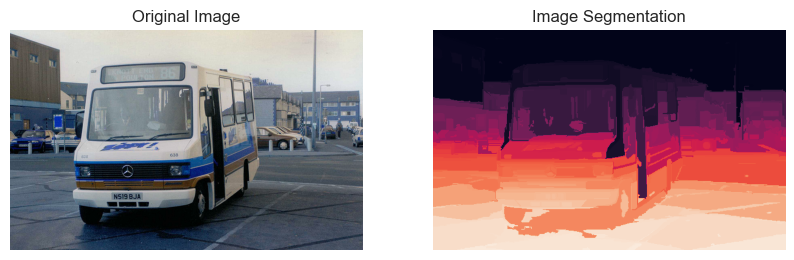

In [67]:
visualization(np_image, segments_fz) 

In [68]:
'''
Now we will extract the candidates from the image using the extract_candidates() function from SelectiveSearch.py.
'''
# Extract Candidates
def extract_candidates(image):
    img_lbl, regions = selectivesearch.selective_search(image, scale=200, min_size=100) # Perform selective search on the input image
    img_area = np.prod(image.shape[:2]) # Calculate the total area of the image
    candidates = []
    for r in regions: # Iterate over the regions returned by selective search on the image
        if r['rect'] in candidates: continue # Skip if the rectangle is already added
        if r['size'] < (0.05*img_area): continue # Skip if the size of the rectangle is less than 5% of the total area of the image
        if r['size'] > (1*img_area): continue # Skip if the size of the rectangle is greater than 100% of the total area of the image
        x, y, w, h = r['rect'] # Extract the coordinates of the rectangle
        candidates.append(list(r['rect'])) # Append the coordinates of the rectangle to the candidates list
    return candidates

In [69]:
candidates = extract_candidates(np_image)

/Users/ashleycui/miniconda3/envs/tf2/lib/python3.11/site-packages/skimage/feature/texture.py:360: UserWarning: Applying `local_binary_pattern` to floating-point images may give unexpected results when small numerical differences between adjacent pixels are present. It is recommended to use this function with images of integer dtype.
  warnings.warn(


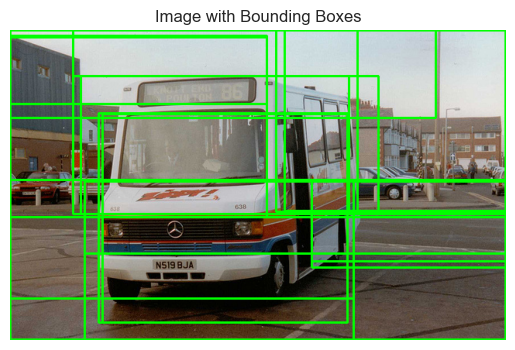

In [70]:
saving_bounding_boxes(np_image, candidates)

In [71]:
model_ = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
model_.eval()

for name, param in model_.named_parameters():
    param.requires_grad = False
print("done")

/Users/ashleycui/miniconda3/envs/tf2/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/ashleycui/miniconda3/envs/tf2/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


done


In [72]:
def model(x):
    with torch.no_grad():
        yhat = model_(x)
    return yhat

In [79]:
test = torch.from_numpy(np_image)
# pred = model([test/255.0])

transform = transforms.Compose([transforms.ToTensor()])
tensor = transform(np_image)
pred = model([tensor])

# images = torchvision.transforms.functional.to_tensor(
#     self.data.iloc[idx, 1:-1].values.astype(np.uint8).reshape((1, 16, 16))
# )


Label: bus
Box coordinates: 118, 52, 454, 357
Probability: 0.9930981993675232


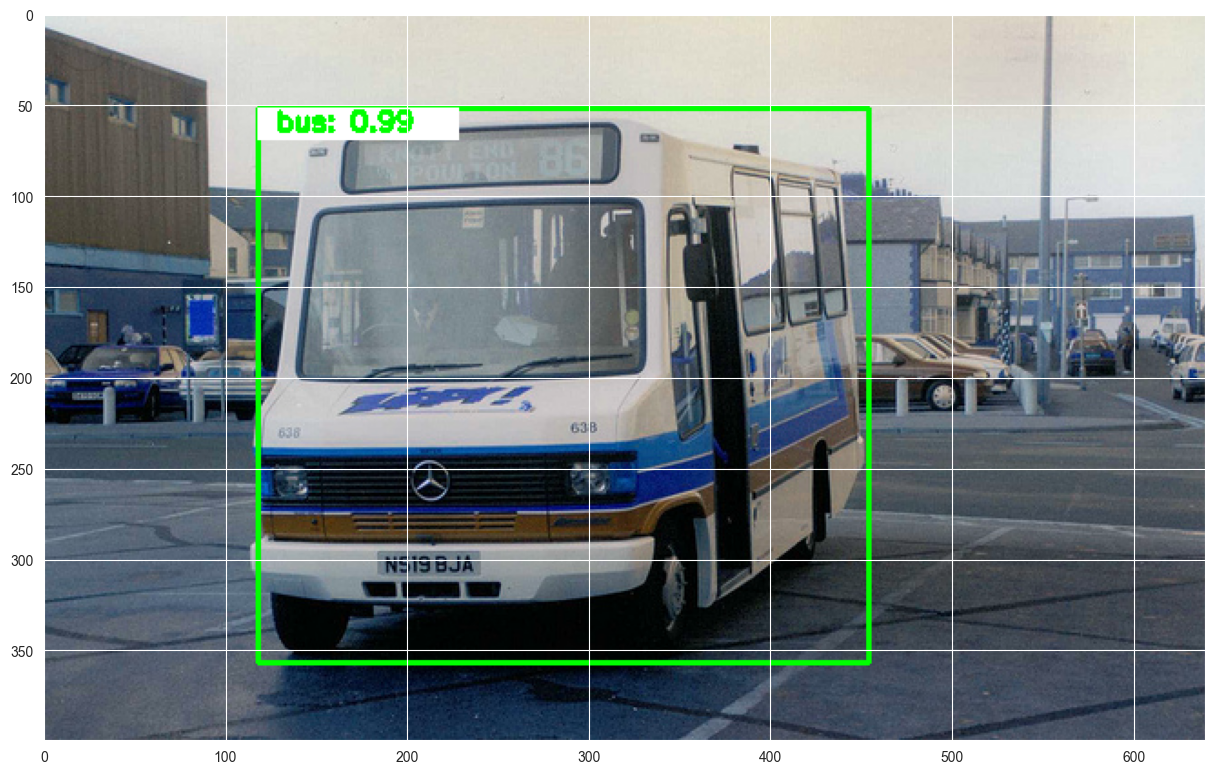

In [82]:
pred_class=get_predictions(pred, objects="bus")
draw_box(pred_class, tensor)

del pred_class